In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib


In [3]:
calories = pd.read_csv('calories.csv')
calories.head()

,User_ID,Calories
0,14733363,231.0
1,14861698,66.0
2,11179863,26.0
3,16180408,71.0
4,17771927,35.0


In [4]:
calories.shape

(15000, 2)

In [5]:
exercise = pd.read_csv('exercise.csv')
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


In [6]:
exercise.shape

(15000, 8)

In [7]:
# Merge the two dataset on the basis of User_ID
df = pd.merge(exercise, calories, on = 'User_ID')

In [8]:
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [9]:
df.shape

(15000, 9)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [11]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [12]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [13]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['Gender'], dtype='object')

In [14]:
# Check for null values
df.isnull().sum()

User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [15]:
# Check for duplicates
df.duplicated().sum()

0

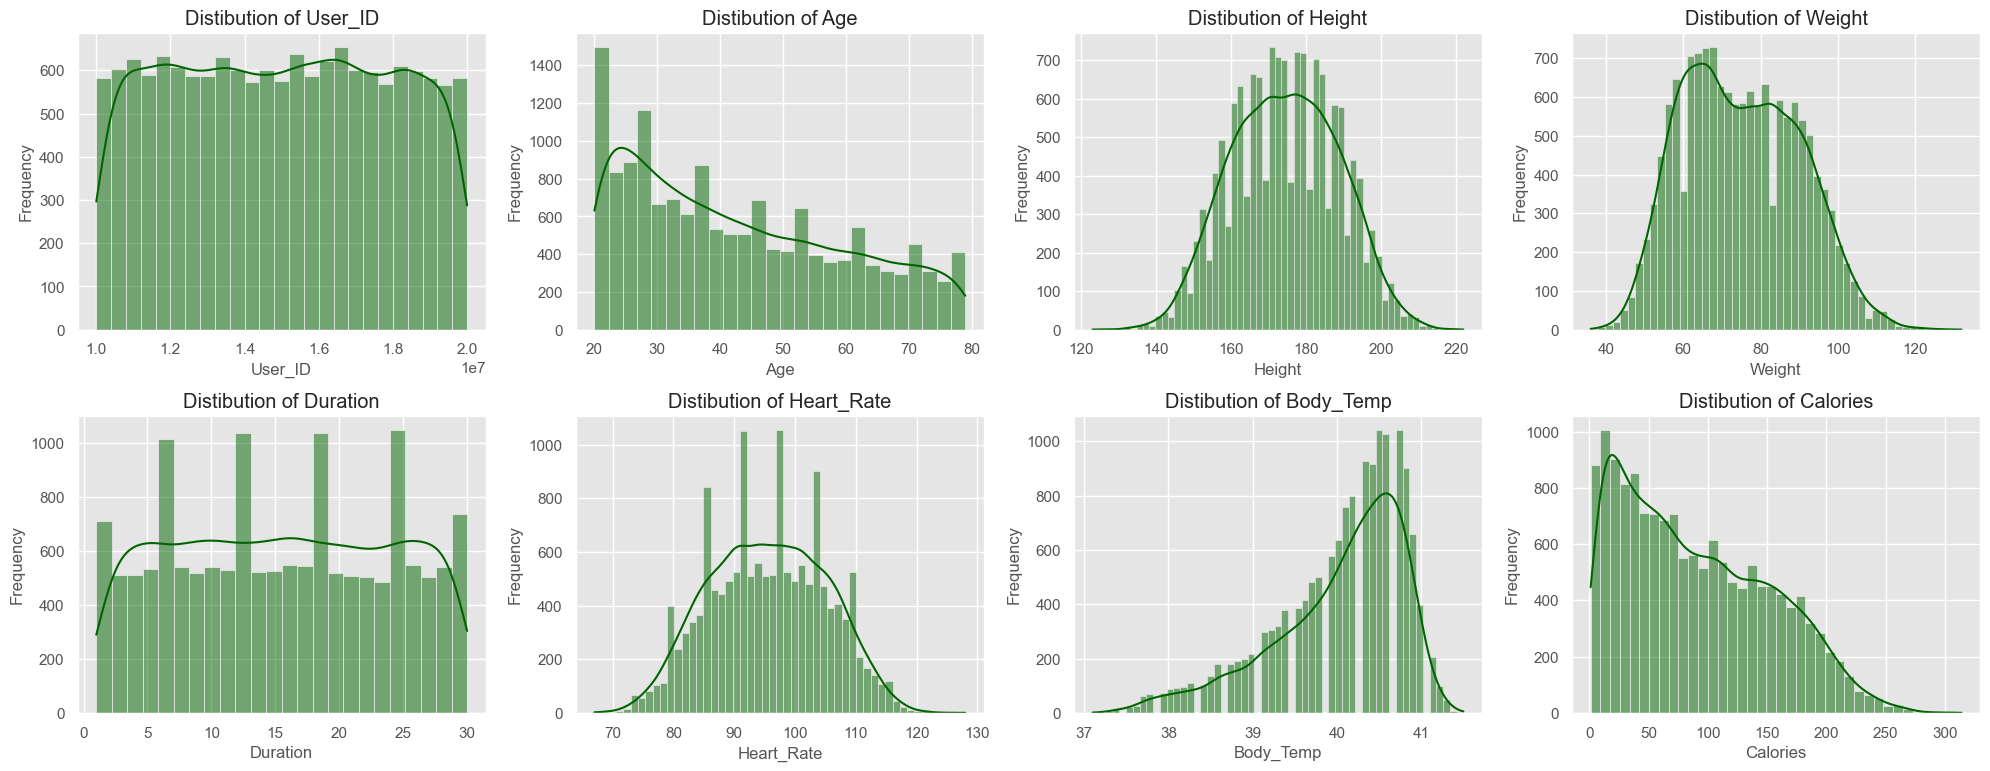

In [16]:
plt.figure(figsize=(20,15))
plt.style.use('ggplot')

for i, col in enumerate(numerical_columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(data=df, x=col, kde=True, palette='virdis', color='darkgreen')
    plt.title(f"Distibution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

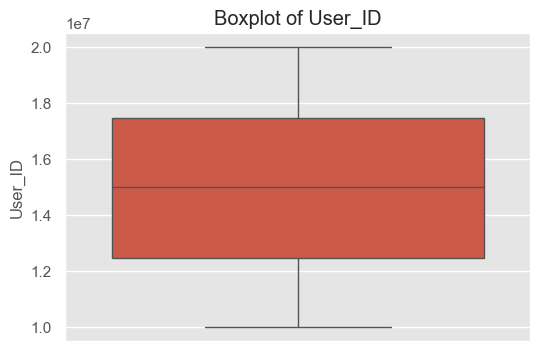

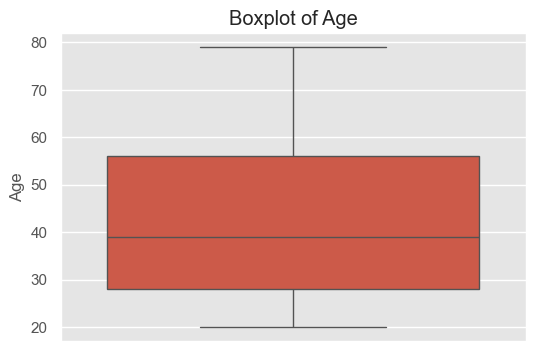

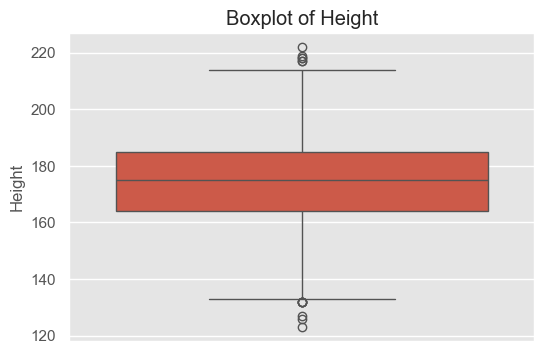

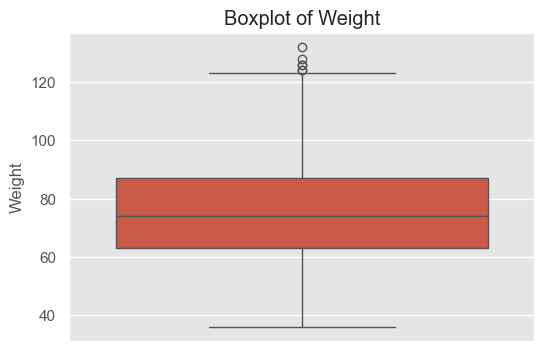

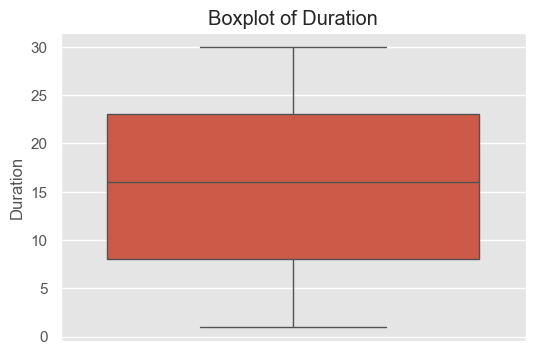

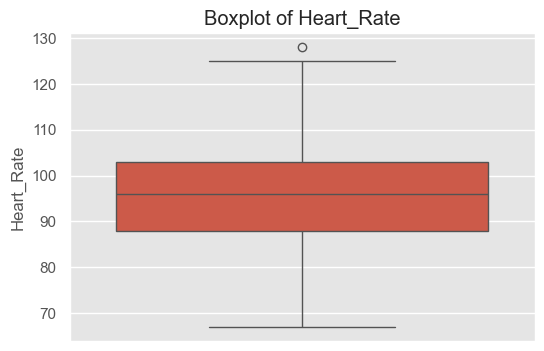

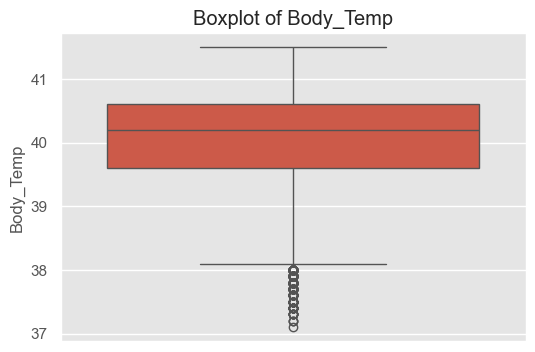

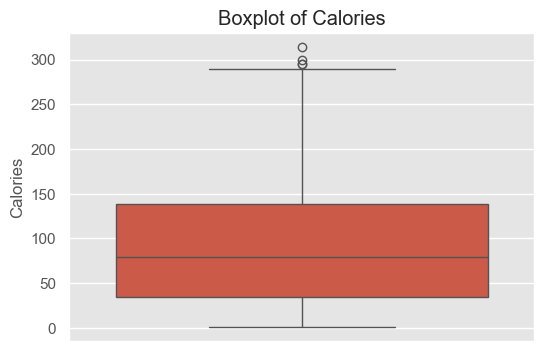

In [17]:
# Boxplots for Outlier Detection
for col in df[numerical_columns]:
    plt.figure(figsize=(6,4))
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

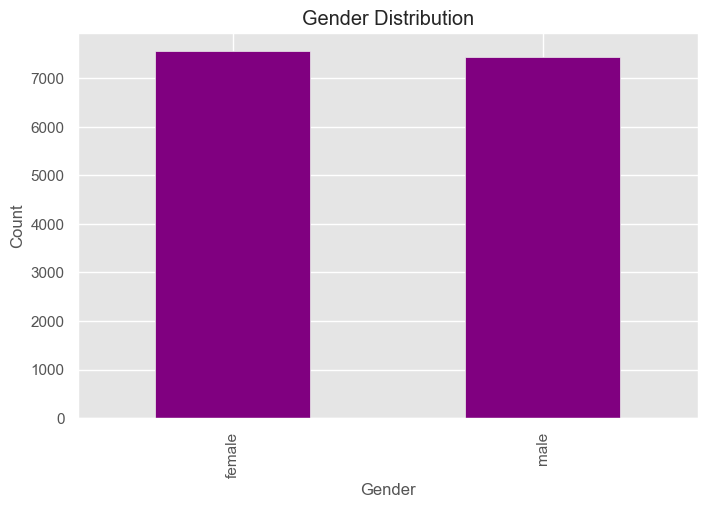

In [18]:
plt.figure(figsize=(8,5))
df['Gender'].value_counts().plot(kind='bar', color='purple')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [19]:
correlation = df[numerical_columns].corr()
correlation

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,1.000000,-0.001827,-0.013520,-0.011603,-0.002751,-0.000457,0.000923,-0.001661
Age,-0.001827,1.000000,0.009554,0.090094,0.013247,0.010482,0.013175,0.154395
Height,-0.013520,0.009554,1.000000,0.958451,-0.004625,0.000528,0.001200,0.017537
Weight,-0.011603,0.090094,0.958451,1.000000,-0.001884,0.004311,0.004095,0.035481
Duration,-0.002751,0.013247,-0.004625,-0.001884,1.000000,0.852869,0.903167,0.955421
Heart_Rate,-0.000457,0.010482,0.000528,0.004311,0.852869,1.000000,0.771529,0.897882
Body_Temp,0.000923,0.013175,0.001200,0.004095,0.903167,0.771529,1.000000,0.824558
Calories,-0.001661,0.154395,0.017537,0.035481,0.955421,0.897882,0.824558,1.000000


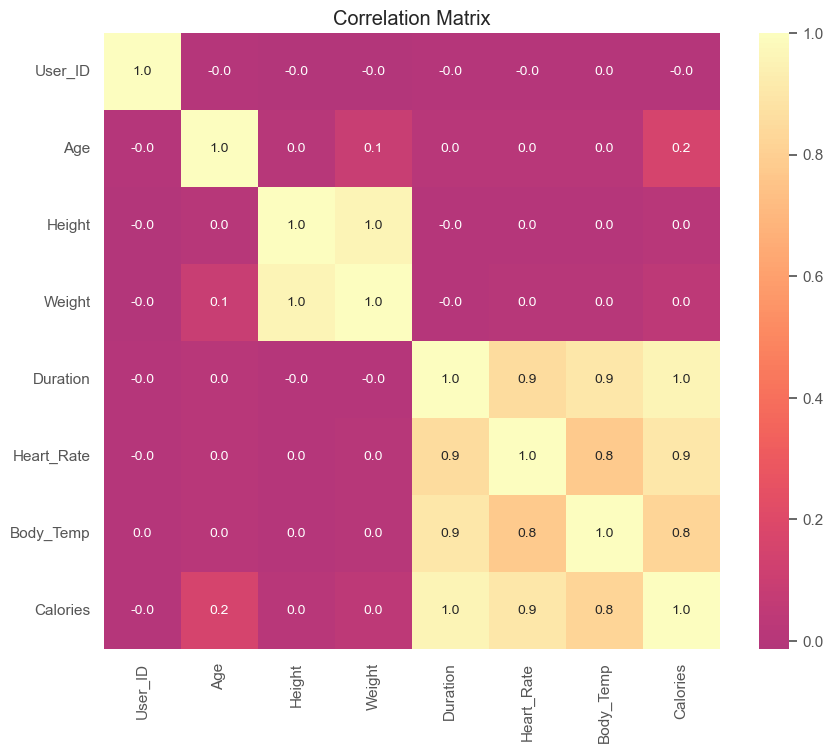

In [20]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='magma', center=0, cbar = True, square=True, fmt = ".1f")
plt.title('Correlation Matrix')
plt.show()

In [21]:
X = df.drop(columns = ['User_ID','Calories'], axis=1)
y= df['Calories']

In [22]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (12000, 7) Test shape: (3000, 7)


In [23]:
## Drop User_ID and Target column 'Calories' from the numerical features
numerical_columns = numerical_columns.drop(['User_ID','Calories'], errors='ignore')
numerical_columns

Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object')

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), categorical_columns),
    ('num', StandardScaler(), numerical_columns)
], remainder='passthrough')

### Randomforest Regressor Model

In [25]:
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(random_state=42))])

In [26]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['Gender'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [27]:
y_pred_rf = rf_pipeline.predict(X_test)

In [28]:
# Evaludate Model
def evaluate_model(y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"R2 score: {r2:.4f}")
    print(f"mse score: {mse:.4f}")
    print(f"RMSE score: {rmse:.4f}")

In [29]:
print("Random Forest Regressor: ")
evaluate_model(y_pred_rf)

Random Forest Regressor: 
R2 score: 0.9983
mse score: 7.0366
RMSE score: 2.6527


### Gradient Boost Regressor Model

In [30]:
gd_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("Regressor", GradientBoostingRegressor(random_state=42))])
gd_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['Gender'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object'))])),
                ('Regressor', GradientBoostingRegressor(random_state=42))])

In [31]:
y_pred_gd = gd_pipeline.predict(X_test)

In [32]:
print("Gradient Boost Regressor: ")
evaluate_model(y_pred_gd)

Gradient Boost Regressor: 
R2 score: 0.9968
mse score: 13.0662
RMSE score: 3.6147


### DecisionTree Regressor Model

In [33]:
dt_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("Regressor", DecisionTreeRegressor(random_state=42))])
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['Gender'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object'))])),
                ('Regressor', DecisionTreeRegressor(random_state=42))])

In [34]:
y_pred_dt = dt_pipeline.predict(X_test)
print("Deecision Tree Regressor: ")
evaluate_model(y_pred_dt)

Deecision Tree Regressor: 
R2 score: 0.9931
mse score: 27.6583
RMSE score: 5.2591


### XGBoost Regressor Model

In [35]:
XGB_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", XGBRegressor(random_state=42))])
XGB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  Index(['Gender'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp'], dtype='object'))])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, cols...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [36]:
y_train_pred_xgb = XGB_pipeline.predict(X_train)
y_pred_xgb = XGB_pipeline.predict(X_test)
print(f"XGBoost Regressor: Training score {r2_score(y_train,y_train_pred_xgb)}")
evaluate_model(y_pred_xgb)

XGBoost Regressor: Training score 0.9995777219604748
R2 score: 0.9989
mse score: 4.5690
RMSE score: 2.1375


In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(XGB_pipeline, X, y, cv = kfold, scoring = 'r2')
cv_results.mean()

0.9988510864545181

In [38]:
joblib.dump(XGB_pipeline, 'best_model.pkl')
print("Model successfully saved as 'best_model'")

Model successfully saved as 'best_model'
